In [1]:
import torch
import torch.nn as nn
from torchvision.models import vgg19, VGG19_Weights, resnet50, ResNet50_Weights, resnet18
import torch.nn.functional as F
import random
import math
import os
import numpy as np
import cv2 as cv
import random
from tqdm import tqdm
import pandas as pd
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import scipy
import scipy.stats
from torch.utils.data import Dataset
import torch.optim as optim

In [2]:
mean = [0.485, 0.456, 0.406]  # RGB
std = [0.229, 0.224, 0.225]

class BBDataset(Dataset):
    def __init__(self, file_dir='dataset', type='train', test=False):
        self.if_test = test
        self.train_transformer = transforms.Compose(
            [
                transforms.ToPILImage(),
                transforms.Resize((224, 224)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean=mean, std=std),
            ]
        )

        self.test_transformer = transforms.Compose(
            [
                transforms.ToPILImage(),
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(mean=mean, std=std),
            ]
        )

        self.images = []
        self.pic_paths = []
        self.labels = []

        if type == 'train':
            DATA = pd.read_csv(os.path.join(file_dir, 'train_set.csv'))
        elif type == 'validation':
            DATA = pd.read_csv(os.path.join(file_dir, 'val_set.csv'))
        elif type == 'test':
            DATA = pd.read_csv(os.path.join(file_dir, 'test_set.csv'))

        labels = DATA['score'].values.tolist()
        pic_paths = DATA['image'].values.tolist()
        for i in tqdm(range(len(pic_paths))):
            pic_path = os.path.join('/kaggle/input/cs4240-78-1', pic_paths[i])
            label = float(labels[i] / 10)
            self.pic_paths.append(pic_path)
            self.labels.append(label)

    def __len__(self):
        return len(self.pic_paths)

    def __getitem__(self, index):
        pic_path = self.pic_paths[index]
        img = cv.imread(pic_path)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        if self.if_test:
            img = self.test_transformer(img)
        else:
            img = self.train_transformer(img)

        return img, self.labels[index]

In [3]:
def calc_mean_std(features):
    batch_size, c = features.size()[:2]
    features_mean = features.reshape(batch_size, c, -1).mean(dim=2).reshape(batch_size, c, 1, 1)
    features_std = features.reshape(batch_size, c, -1).std(dim=2).reshape(batch_size, c, 1, 1) + 1e-6
    return features_mean, features_std


def adain(content_features, style_features):
    content_mean, content_std = calc_mean_std(content_features)
    style_mean, style_std = calc_mean_std(style_features)
    normalized_features = style_std * (content_features - content_mean) / content_std + style_mean
    return normalized_features


class NonLocalBlock(nn.Module):
    def __init__(self, in_channels, inter_channels=None, sub_sample=True, bn_layer=True):
        super(NonLocalBlock, self).__init__()

        self.sub_sample = sub_sample

        self.in_channels = in_channels
        self.inter_channels = inter_channels

        if self.inter_channels is None:
            self.inter_channels = in_channels // 2
            if self.inter_channels == 0:
                self.inter_channels = 1

        conv_nd = nn.Conv2d
        max_pool_layer = nn.MaxPool2d(kernel_size=(2, 2))
        bn = nn.GroupNorm

        self.g = conv_nd(in_channels=self.in_channels, out_channels=self.inter_channels,
                         kernel_size=1, stride=1, padding=0)

        if bn_layer:
            self.W = nn.Sequential(
                conv_nd(in_channels=self.inter_channels, out_channels=self.in_channels,
                        kernel_size=1, stride=1, padding=0),
                bn(16, self.in_channels)
            )
            nn.init.constant_(self.W[1].weight, 0)
            nn.init.constant_(self.W[1].bias, 0)
        else:
            self.W = conv_nd(in_channels=self.inter_channels, out_channels=self.in_channels,
                             kernel_size=1, stride=1, padding=0)
            nn.init.constant_(self.W.weight, 0)
            nn.init.constant_(self.W.bias, 0)

        self.theta = conv_nd(in_channels=self.in_channels, out_channels=self.inter_channels,
                             kernel_size=1, stride=1, padding=0)
        self.phi = conv_nd(in_channels=self.in_channels, out_channels=self.inter_channels,
                           kernel_size=1, stride=1, padding=0)

        if sub_sample:
            self.g = nn.Sequential(self.g, max_pool_layer)
            self.phi = nn.Sequential(self.phi, max_pool_layer)

    def forward(self, x):
        batch_size = x.size(0)

        g_x = self.g(x).view(batch_size, self.inter_channels, -1)
        g_x = g_x.permute(0, 2, 1)

        theta_x = self.theta(x).view(batch_size, self.inter_channels, -1)
        theta_x = theta_x.permute(0, 2, 1)
        phi_x = self.phi(x).view(batch_size, self.inter_channels, -1)
        f = torch.matmul(theta_x, phi_x)
        f_div_C = F.softmax(f, dim=-1)

        y = torch.matmul(f_div_C, g_x)
        y = y.permute(0, 2, 1).contiguous()
        y = y.view(batch_size, self.inter_channels, *x.size()[2:])
        W_y = self.W(y)
        z = W_y + x

        return z

In [4]:
class VGG(nn.Module):   # output relu4-1
    def __init__(self):
        super(VGG, self).__init__()
        model = vgg19()
        model.load_state_dict(torch.load('/kaggle/input/baid/pytorch/fully_pretrained/2/vgg19-dcbb9e9d.pth'),
                                        strict=False)
        self.model = nn.Sequential(*model.features[:21])
        self._freeze_params()

    def forward(self, x):
        x = self.model(x)
        return x

    def _freeze_params(self):
        for p in self.model.parameters():
            p.requires_grad = False


class SAB(nn.Module):
    def __init__(self, identity=False):
        super(SAB, self).__init__()
        model = resnet50()
        self.model = nn.Module()
        self.model.conv1 = model.conv1
        self.model.bn1 = model.bn1
        self.model.relu = model.relu
        self.model.maxpool = model.maxpool

        self.model.layer1 = model.layer1
        self.model.layer2 = model.layer2

        self.identity = identity

        self.vgg = VGG()

        self._init_weights()

    def forward(self, x):
        # aligned to the output of VGG
        sty = self.vgg(x)
        aes = self.model.conv1(x)
        aes = self.model.bn1(aes)
        aes = self.model.relu(aes)
        aes = self.model.maxpool(aes)

        aes = self.model.layer1(aes)
        aes = self.model.layer2(aes)

        output = adain(aes, sty)
        if self.identity:
            output += aes

        return F.relu(output)

    def _init_weights(self):
        if torch.cuda.is_available():
            self.model.load_state_dict(torch.load('/kaggle/input/baid/pytorch/fully_pretrained/2/epoch_99.pth'),
                                        strict=False)
        else:
            self.model.load_state_dict(torch.load('/kaggle/input/baid/pytorch/fully_pretrained/2/epoch_99.pth', map_location=torch.device('cpu')),
                                        strict=False)


class GAB(nn.Module):
    def __init__(self):
        super(GAB, self).__init__()
        model = resnet50()
        self.model = nn.Module()
        self.model.conv1 = model.conv1
        self.model.bn1 = model.bn1
        self.model.relu = model.relu
        self.model.maxpool = model.maxpool

        self.model.layer1 = model.layer1
        self.model.layer2 = model.layer2
        self.model.layer3 = model.layer3

        self._init_weights()

    def forward(self, x):
        x = self.model.conv1(x)
        x = self.model.bn1(x)
        x = self.model.relu(x)
        x = self.model.maxpool(x)

        x = self.model.layer1(x)
        x = self.model.layer2(x)
        x = self.model.layer3(x)

        return x

    def _init_weights(self):
        if torch.cuda.is_available():
            self.model.load_state_dict(torch.load('/kaggle/input/baid/pytorch/fully_pretrained/2/epoch_99.pth'),
                                        strict=False)
        else:
            self.model.load_state_dict(torch.load('/kaggle/input/baid/pytorch/fully_pretrained/2/epoch_99.pth', map_location=torch.device('cpu')),
                                        strict=False)
class SAAN(nn.Module):
    def __init__(self, num_classes) -> None:
        super().__init__()
        self.GenAes = GAB()
        self.StyAes = SAB()

        self.NLB = NonLocalBlock(in_channels=1536)

        self.max_pool = nn.MaxPool2d(3, stride=2, padding=1)
        self.avg_pool = nn.AdaptiveAvgPool2d(output_size=(2, 2))

        self.bn = nn.GroupNorm(16,1536)

        self.predictor = nn.Sequential(
            nn.Linear(1536 * 4, 2048),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(2048, num_classes),
            nn.Sigmoid(),
        )

        self._initial_weights()

    def forward(self, x):
        gen_aes = self.GenAes(x)
        sty_aes = self.StyAes(x)

        sty_aes = self.max_pool(sty_aes)

        all_aes = torch.cat((sty_aes, gen_aes), 1)
        all_aes = self.NLB(all_aes)

        all_aes = self.avg_pool(all_aes)
        all_aes = self.bn(all_aes)

        fc_input = torch.flatten(all_aes, start_dim=1)

        output = self.predictor(fc_input)

        return output

    def _initial_weights(self):
        for m in self.bn.modules():
            if isinstance(m, nn.GroupNorm):
                nn.init.normal_(m.weight.data, mean=1.0, std=0.02)
                nn.init.constant_(m.bias.data, 0.0)

        for m in self.predictor.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight.data, mean=0.0, std=0.02)
                nn.init.constant_(m.bias.data, 0.0)


class ResNetPretrain(nn.Module):
    def __init__(self, num_classes):
        super(ResNetPretrain, self).__init__()
        model = resnet50()
        self.model = model
        self.model.fc = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(in_features=2048, out_features=num_classes, bias=True),
            nn.Softmax(dim=1),
        )

        self._initial_weights()

    def forward(self, x):
        x = self.model.conv1(x)
        x = self.model.bn1(x)
        x = self.model.relu(x)
        x = self.model.maxpool(x)

        x = self.model.layer1(x)
        x = self.model.layer2(x)
        x = self.model.layer3(x)
        features = self.model.layer4(x)
        features_flat = self.model.avgpool(features)
        features_flat = torch.flatten(features_flat, 1)
        output = self.model.fc(features_flat)

        return features, output

    def _initial_weights(self):
        for m in self.model.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if isinstance(m, nn.GroupNorm):
                nn.init.normal_(m.weight.data, 1.0, 0.02)
                nn.init.constant_(m.bias.data, 0.0)
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0.0, std=0.02)
                nn.init.constant_(m.bias, 0.0)

                



n_epochs = 44
batch_size = 16
validation_frequency = 2
save_frequency = 2
learning_rate = 1e-5
device = "cuda"
checkpoint_dir = "/kaggle/working/SAAN"

train_dataset = BBDataset(file_dir='/kaggle/input/baid-csvs', type='train', test=False)
val_dataset = BBDataset(file_dir='/kaggle/input/baid-csvs', type='validation', test=True)


def adjust_learning_rate(learning_rate, optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 10 epochs"""
    if epoch < 40:
        lr = learning_rate * (0.1 ** (epoch // 10))
    else:
        lr = learning_rate * (0.1 ** 4)

    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


def save_checkpoint(checkpoint_dir, model, epoch):
    checkpoint_dir = checkpoint_dir
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    save_path = os.path.join(checkpoint_dir, f"epoch_{epoch}.pth")
    torch.save(model.state_dict(), save_path)
    
def validate(model, val_loader, epoch):
    model.eval()

    loss = nn.HuberLoss()
    val_loss = 0.0
    with torch.no_grad():
        for step, val_data in enumerate(val_loader):
            image = val_data[0].to(device)
            label = val_data[1].to(device).float()

            predicted_label = model(image).squeeze()
            val_loss += loss(predicted_label, label).item()

    val_loss /= len(val_loader)
    print("Epoch: %3d Validation loss: %.8f" % (epoch, val_loss))


def train():
    loss_hist = []
    model = SAAN(num_classes=1)
    for name, param in model.named_parameters():
        if 'GenAes' in name:
            param.requires_grad = False
    model = model.to(device)

    loss = nn.HuberLoss()

    optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(0.5, 0.999), weight_decay=5e-4)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=8)
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, pin_memory=True)

    for epoch in range(n_epochs):
        model.train()
        epoch_loss = 0.0

        for step, train_data in enumerate(train_loader):
            optimizer.zero_grad()
            image = train_data[0].to(device)
            label = train_data[1].to(device).float()

            predicted_label = model(image).squeeze()
            train_loss = loss(predicted_label, label)

            train_loss.backward()
            optimizer.step()

            epoch_loss += train_loss.item()

        print("Epoch: %3d Step: %5d / %5d Train loss: %.8f" % (epoch, step, len(train_loader), train_loss.item()))
        loss_hist.append(epoch_loss)
        adjust_learning_rate(learning_rate, optimizer, epoch)

        if (epoch + 1) % validation_frequency == 0:
            validate(model, val_loader, epoch)
            print("Validation")

        if (epoch + 1) % save_frequency == 0:
            save_checkpoint(checkpoint_dir, model, epoch)
            print("Saved")
        

    print("Done training")
    return loss_hist



# Uncomment when you want to train
# Might take up to a day to train on two GPU T4.


100%|██████████| 3200/3200 [00:00<00:00, 268285.22it/s]


In [5]:
loss_hist = train()


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch:   0 Step:  3171 /  3172 Train loss: 0.00221599


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/loss.py:993: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.huber_loss(input, target, reduction=self.reduction, delta=self.delta)


Epoch:   1 Step:  3171 /  3172 Train loss: 0.00420552
Epoch:   1 Validation loss: 0.00799185
Validation
Saved
Epoch:   2 Step:  3171 /  3172 Train loss: 0.00525758
Epoch:   3 Step:  3171 /  3172 Train loss: 0.00374830
Epoch:   3 Validation loss: 0.00671189
Validation
Saved
Epoch:   4 Step:  3171 /  3172 Train loss: 0.00462402
Epoch:   5 Step:  3171 /  3172 Train loss: 0.00444665
Epoch:   5 Validation loss: 0.00720812
Validation
Saved
Epoch:   6 Step:  3171 /  3172 Train loss: 0.00307403
Epoch:   7 Step:  3171 /  3172 Train loss: 0.00388863
Epoch:   7 Validation loss: 0.00686541
Validation
Saved
Epoch:   8 Step:  3171 /  3172 Train loss: 0.00099007
Epoch:   9 Step:  3171 /  3172 Train loss: 0.01106400
Epoch:   9 Validation loss: 0.00728497
Validation
Saved
Epoch:  10 Step:  3171 /  3172 Train loss: 0.00879841
Epoch:  11 Step:  3171 /  3172 Train loss: 0.00766072
Epoch:  11 Validation loss: 0.00691350
Validation
Saved
Epoch:  12 Step:  3171 /  3172 Train loss: 0.10371203
Epoch:  13 Step:

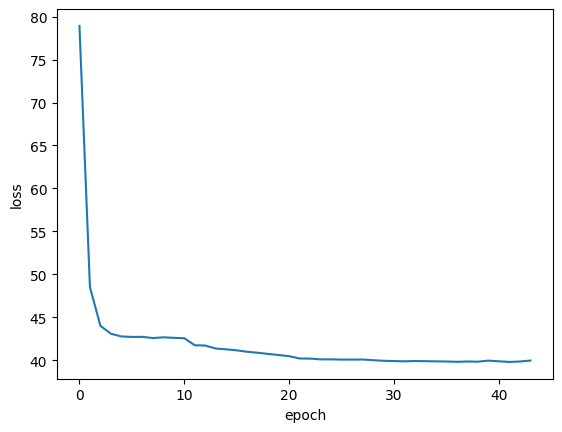

In [6]:
## Loss plot
import matplotlib.pyplot as plt

plt.figure()
plt.plot(loss_hist)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [7]:
test_dataset = BBDataset(file_dir='/kaggle/input/baid-csvs', type='test', test=True)



def test():
    device = "cuda"
    checkpoint_path = "/kaggle/working/SAAN/epoch_43.pth"
    df = pd.read_csv('/kaggle/input/baid-csvs/test_set.csv')
    predictions = []

    model = SAAN(num_classes=1)
    model = model.to(device)
    model.load_state_dict(torch.load(checkpoint_path))
    model.eval()

    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, pin_memory=True, num_workers=8)
    print("test")
    with torch.no_grad():
        for step, test_data in tqdm(enumerate(test_loader)):
            image = test_data[0].to(device)

            predicted_label = model(image)
            prediction = predicted_label.squeeze().cpu().numpy()
            predictions.append(prediction * 10)

    scores = df['score'].values.tolist()

    print(scipy.stats.spearmanr(scores, predictions))
    print(scipy.stats.pearsonr(scores, predictions))

    acc = 0
    for i in range(len(scores)):
        cls1 = 1 if scores[i] > 5 else 0
        cls2 = 1 if predictions[i] > 5 else 0
        if cls1 == cls2:
            acc += 1
    print(acc/len(scores))
    df.insert(loc=2, column='prediction', value=predictions)
    
    save_dir = '/kaggle/working'

    save_path = os.path.join(save_dir, 'result.csv')
    df.to_csv(save_path, index=False)
    print("done")

test()

100%|██████████| 6400/6400 [00:00<00:00, 335192.37it/s]


test


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
6400it [02:09, 49.50it/s]


SignificanceResult(statistic=0.46820528171712694, pvalue=0.0)
PearsonRResult(statistic=0.48198943472598027, pvalue=0.0)
0.77375
done
